#Creating a Shakespearean Recommender System using PCA and Kmeans:
Synopsis:
William Shakespeare is considered one of the greatest playwrights in the English language. He is attributed with 38 plays, 154 sonnets, and other works. Even 400 years later, his writings are still be studied in most high schools and colleges in the US and elsewhere. Shakespeare’s complete works are available online at http://shakespeare.mit.edu/.  We will be using a data set which has Shakespeare character quotes.  A lot of people are fascinated by the characters in the Shakespeare plays.  The first first part of the assignment is to create a Shakespeare character recommender system which is capable of recommending new characters which are similar to a speicific character of interest.  We will also explore using PCA inference to find important words in character quotes.  In the second part of the assignment we will use K-Means clustering to try and find one or more character insights.



The following cell reads the data files needed for this homework from github and stores it on your local colab instance.


In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./quotes_by_char.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/quotes_by_char.csv  
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=975ab19344faa0210b6cf487374ab26bf9d736e44654fbd9b4e64a93d9199de5
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-12-09 16:28:08--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/quotes_by_char.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352265 (4.2M) [text/plain]
Saving to: ‘quotes_by_char.csv’

     0K .......... .......... .......... .......... ..........  1% 6.53M 1s
    50K .......... .......... .......... .......... ..........  2% 19.7M 0s
   100K .......... .......... .......... .......... ..........  3% 7.00M 0s
   150K .......... .......... .......... .......... ..........  4% 23.7M 0s
   200K .......... .......... .......... .......... ..........  5% 13.3M 0s
   250K .......... .......... .......... .......... ..........  7% 40.0M 0s
   300K .......... .......... .......... .......... ..........  8% 38.4M 0s
   350K .......... .......

# Part 1: Shakespeare Recommender System

# Reading in and cleaning up our Dataframe 
Read the quotes_by_char.csv file into a spark dataframe named `quotes_by_char_df`.  Drop the `Unnamed` column.  Transform the character column such that all character names are lower case.

In [2]:
# import statements
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#spark = SparkSession.builder.getOrCreate()
#here, we modify the configuration of our spark context by changing the maxresult size, off heap, driver and executor memory to 12 gigabytes
#almost all problems within this notebook were solved by modifying these configuration settings
spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .config("spark.driver.maxResultSize", "12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import pandas as pd
#reading in our Shakespearean character quotations file as a CSV
quotes_by_char_df = spark.read.format("csv").option("header", "true").load("quotes_by_char.csv")
from pyspark.sql.functions import lower, col
#we only need to deal with the following two columns for the sake of this homework
quotes_by_char_df = quotes_by_char_df.select(['character','all_quotes'])
#lowercasing out data and removing certain special characters was useful in ensuring that our data was uniformally formatted, making analysis much simpler
quotes_by_char_df  = quotes_by_char_df.select('all_quotes',lower(col('character'))).alias('lower_character')
quotes_by_char_df = quotes_by_char_df.withColumnRenamed('lower(character)', 'character')
quotes_by_char_df = quotes_by_char_df.replace('& c','courtezan')
quotes_by_char_df = quotes_by_char_df.sort('character')

In [4]:
display(quotes_by_char_df.toPandas().head())

,all_quotes,character
0,"Sir, it was I.",a lord
1,This man has marr'd his fortune. You do the no...,a patrician
2,So please your lordship to accept our duty. I ...,a player
3,"Now climbeth Tamora Olympus' top, Safe out of ...",aaron
4,"A woeful pageant have we here beheld. My lord,...",abbot


# Vectorizing textual data and creating a ML pipeline for our PCA object
Create a spark pipeline named `pipe_pca_1` which performs Principal Component Analysis (PCA) on `chars_df`.  Use `pipe_pca_1` to create a new dataframe named `chars_pca_df`.  Analyze the resulting number of TF-IDF data rows and columns in your data.  Add code to the specially marked code cell below which prints the number of rows and cols in your TF-IDF data.  Using the analysis for the number of rows and cols in the data, explicitly set the K parameter in the spark PCA object equal to the maximum number of principal components.  Your overall solution should use sound data science techniques as outlined in lecture for making TF-IDF and PCA score calculations. We will be looking closely at how these calculations are made during the grading process.

In [5]:
# your code here
import nltk
from pyspark.ml.feature import Tokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import PCA 
from pyspark.ml import Pipeline
#tokenizing the quotations column and applying a regex pattern to only isolate words that we want for PCA and kmeans
tokenizer = RegexTokenizer().setInputCol('all_quotes').setOutputCol('words').setGaps(False).setPattern("\\p{L}+")
#pulling our stopwords via a url request. I have also experimented with removing elizabethan stopwords 
#but didn't yield better results which led me to stick with the first option
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
#stop_words = requests.get('https://raw.githubusercontent.com/BryanBumgardner/gutenburg_nlp/master/stopwords_elizabethan').text.split()

In [6]:
# TF-IDF
# We use TF-IDF opposed toBag Of Words because in BOW, each word has a similar significance considering its weight 
# amongst all documents. To reckon with this, the TF-IDF approach in classification tends to make sure that more weight should be 
# given to words or terms which are more frequent throughout the document than others(where the frequency of ​these​ words or the term 
# is comparatively lower). The term frequency can thus be calculated as:  Term Frequency (TF)  T=Total number of words or terms in the documentNumber of times the word 
# or the term appears in the document  Moving further, the Inverse Document Frequency or IDF for a particular word will be the total number of documents,
#  divided by only the documents in which that particular word is found.  To reduce the effect of this division, we calculate the logarithm of its ratio.
# The Inverse Document Frequency or IDF can thus be calculated as: nverse Document Frequency (IDF) ㏒ ()I= Total number of documentsNumber of documents 
# which have that word  We can further conclude here that TF-IDF is a product of two terms: TF and IDF. Following this, our vectorized tweets were ready 
# to have PCA applied.   

In [ ]:
#Filtering out stop words from our tokenized data
sw_filter = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered")
#applying a count vectorizer with a minTF of 1 and minDF of 5. These parameters were decided after extensively reviewing documentation and discussion available on piazza
cv = CountVectorizer(minTF=1., minDF=5.).setInputCol("filtered").setOutputCol("tf")
#running idf on our vectorized tf column
idf = IDF().setInputCol('tf').setOutputCol('tfidf')
#applying PCA with k = 500. This value was tweaked constantly and took the least time to execute while still explaining a large portion of the variance within our data
pca = PCA(k=500, inputCol='tfidf', outputCol='scores')
#passing each of the aforementioned steps into the pipeline and fit transforming on our quotes_by_char_df
pipe_pca_1 = Pipeline(stages=[tokenizer, sw_filter, cv, idf, pca]).fit(quotes_by_char_df)
chars_pca_df = pipe_pca_1.transform(quotes_by_char_df)

In [ ]:
# your code here to print the number of rows and cols in the TF-IDF data in chars_pca_df here
#printing the rows and columns from our TF-IDF data
rowss = chars_pca_df.count()
colss = np.array(chars_pca_df.select('tfidf').rdd.map(lambda x: x['tfidf']).collect())
print("Number of rows in TF-IDF Data:", rowss, "\nNumber of columns in TF-IDF Data:", colss.shape[1])
# The "scores" we obtain from this are created by projecting the data observations onto the loading vectors we obtained in question 3. 
# Each projection is created by multiplying the observations by the loading vectors which will effective project each observation in the direction
# that the loading vector is pointing.

Number of rows in TF-IDF Data: 966 
Number of columns in TF-IDF Data: 7420


In [ ]:
display(chars_pca_df.toPandas().head())

# Analyzing PCA data 
Analyze the PCA data in `chars_pca_df`.  Create scree and cumulative variance explained plots.  Assuming you were trying to reduce the number of columns to train a machine learning model, how many princiapal components would you pick such that the number of data columns is reduced from the original data set but you still capture a reasonable amount of variance in the data.  Describe in words the number of principal components you would choose and how you arrived at that number of components.

In [ ]:
#First we obtain the loading vectors from the pca pipeline. In PCA, we are essentially splitting our
#correlation matrix into scales and direction via eigen values and eigen vectors, respectively. These loadings are
#then comparable by magnitude and covariance between variables. To reiterate, loadings can be thought of as 
#the covariances between our original attributes and the normalized or unit-scaled components.
#Therefore, these value represent phi coefficients, that help us interpret principle components.
#Phi coefficients are used to perform the linear combination of column vectors in our data.
#Since loadings are the linear combination coefficents where normalized factors actually load the variable itself.
#The column vectors form the linear combinations that create principal components where each one will capture a degree 
#of variance within our data. PC1 always captures the highest degree of variance, while PC2 will capture the next highest. 
#To visualize this, we put our vectors into a dimensional space where p is the number of attributes in the dataset. 
#Therefore each loading vector will denote a specific direction associated with our PC's.
#Now that we have a bit of background, we will proceed.
loadings = pipe_pca_1.stages[-1].pc.toArray()
#printing the shape of our loading vectors
print("loadings.shape", loadings.shape)
# prints the first column of the loading matrix - the first principal component
print(loadings[:,0])

loadings.shape (7420, 500)
[-1.46348380e-01 -2.61477494e-01 -1.45835586e-01 ... -1.32819335e-03
 -5.13164835e-04 -1.26086049e-04]


In [ ]:
pipe_pca_1.stages[-1].explainedVariance

In [ ]:
# Next we can sum the components within this vector to find the percentage of variance captured by each PC. 
#The first component captured ~ 15% of the total variance within quotes_by_char_df
print('Proportion of Explained Variance associated with each PC', sum(pipe_pca_1.stages[-1].explainedVariance))

Proportion of Explained Variance associated with each PC 0.9837250456052189


Text(0, 0.5, 'Proportion Variance Explained')

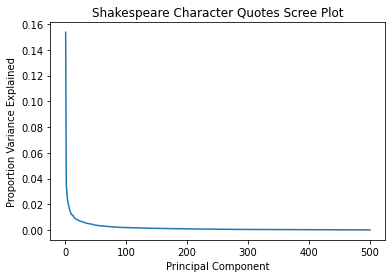

In [ ]:
# your code here
#Next, we create scree plots to analyze the Proportion of Explained Variance for our 500 principle components
import numpy as np 
plt.figure()
explained_var = pipe_pca_1.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Shakespeare Character Quotes Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

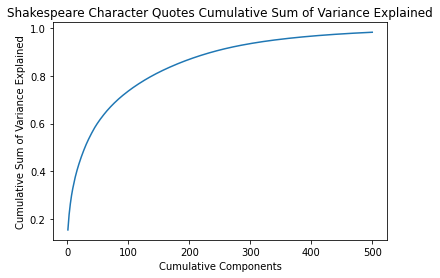

In [ ]:
#This plot uses the cumulative sum of the explained variance for each of our principle components
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Shakespeare Character Quotes Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

Your explanation here: 
First we obtain the loading vectors from the pca pipeline. In PCA, we are essentially splitting our
correlation matrix into scales and direction via eigen values and eigen vectors, respectively. These loadings are
then comparable by magnitude and covariance between variables. To reiterate, loadings can be thought of as 
the covariances between our original attributes and the normalized or unit-scaled components.
Therefore, these value represent phi coefficients, that help us interpret principle components.
Phi coefficients are used to perform the linear combination of column vectors in our data.
Since loadings are the linear combination coefficents where normalized factors actually load the variable itself.
The column vectors form the linear combinations that create principal components where each one will capture a degree 
of variance within our data. PC1 always captures the highest degree of variance, while PC2 will capture the next highest. 
To visualize this, we put our vectors into a dimensional space where p is the number of attributes in the dataset. 
Therefore each loading vector will denote a specific direction associated with our PC's.
Following this we can sum the components within this vector to find the percentage of variance captured by each PC. The first component captured ~ 15% of the total variance within quotes_by_char_df.
Next, we create scree plots to analyze the Proportion of Explained Variance for our 500 principle components. This plot uses the cumulative sum of the explained variance for each of our principle components



# Finding the most Similar Characters based on PCA
In this question your will write code which makes recommendations on new characters to study based on a specific character that a Shakespeare fan likes.

Create a function named get_nearest_chars that takes 2 arguments: char and num_nearest_chars. The char arg is a string which defines the character for which we are interested in finding similar characters. The num_nearest_chars arg is an integer that defines the total number of nearest characters which we want included in the return list. The get_nearest_chars function shall perform all of its internal operations in spark and return a python list containing a string corresponding to each of the nearest characters defined by num_nearest_chars. Compute the list of characterss which are closest to the char arg using L2 Euclidian distance. 

Hint: Start by creating a new pipe named pipe_pca_2 that is the same as pipe_pca_1 except set K equal to 2 when instantiating the PCA object. We are essentially fixing the number of PCA components to 2 so that we will limit the Euclidian distance to 2 dimensions for this problem. 

Your get_nearest_chars function should rigorously error check input data to verify that the user is not making illegal requests. We plan on trying your code against secret tests which verify your error checking to make the challenge more interesting. You are free to break the problem up into as many sub functions as you wish but you must implement get_nearest_chars as the top level entry point to your code.

In [ ]:
# To reiterate on PCA, this method finds new directions based on a covariance matrix of original variables. 
# Given that covariance values are sensitive to variable standardization which can assign equal weights to all variables, if 
# we don't standardize the variables before utilizing PCA, then we will get misleading directions in some cases.
# However if all the variables are in same scale, it's not necessary to scale variables.
# Since PCA reduces the dimensionality of our data based on variance we encounter a tradeoff between the two. 
# The algorithm is trying to maximize variance for a given dimensionality reduction. 
#So if the scale of a feature is changed from g to mg, the resulting variance of the attribute would now be 1000 
#more than it was. The problem with this is that the attribute would now play a disproportionate role in deciding the first principal component given that the algorithm is trying to
# maximize variance. 
#K-Means Clustering is an unsupervised learning algorithm that allows data to be naturally segregated solely based on our vectorized text. 
#The algorithm is distance-based and tries to simply minimize the SSE (intra or within-cluster variation) to produce coherent clusters.  
#This should serve as an adequate precursor to the center and normalization stages in our second pca pipeline.

In [ ]:
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')
#we use p=2 for the normalizer to specify that we want to use the euclidean distance
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)
#k was set to 5 in order to optimize time spent on running this cell. This value was iteratively updated after extensively 
#reviewing the discussion forum of piazza.
kmeans = clustering.KMeans(k=5, featuresCol='norm_tfidf', predictionCol='kmeans_feat')
pca = PCA(k=500, inputCol='centered_tfidf', outputCol='pca_scores')
pipe_pca_2 = Pipeline(stages=[tokenizer, sw_filter, cv, idf, center, norm, kmeans, pca]).fit(quotes_by_char_df)

In [ ]:
#we transform our original dataframe after passing it through the pipe_pca_2 pipeline 
df = pipe_pca_2.transform(quotes_by_char_df)

In [ ]:
#creating our function to find the l2 distance between a vector(character) and all other characters
from pyspark.sql import types
import numpy as np
def findl2(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))
#Following this we invoke a udf that will use the findl2 function created above 
#that will take two columns (vectors) as input and returns the euclidean distance that separates them. 
#We also must specify that we are taking float datatypes in this use case
l2_dist_udf = fn.udf(findl2, types.FloatType())
#this function will take a character, select their pca scores, and find whichever number of specified characters 
#are the closest to them in terms of l2 distance
def get_nearest_chars(char, num_nearest_char):
  dfq4 = df.\
  where(df.character == char).\
  select(fn.col('pca_scores').alias('new_scores')).\
  join(df).\
  withColumn('dist', l2_dist_udf('pca_scores', 'new_scores')).\
  select("character", "kmeans_feat", "dist").\
  orderBy(fn.asc("dist"))
  return dfq4.show(num_nearest_char + 1)

In [ ]:
print(get_nearest_chars('first watchman', 5)) 

+---------------+-----------+---------+
|      character|kmeans_feat|     dist|
+---------------+-----------+---------+
| first watchman|          4|      0.0|
|second watchman|          1|31.616182|
| third watchman|          1|32.585102|
|          nurse|          1|33.170227|
|  second drawer|          1| 33.19214|
|second musician|          1| 33.26626|
+---------------+-----------+---------+
only showing top 6 rows

None


In [ ]:
# grading cell - do non modify
print(get_nearest_chars('romeo', 5))
print(get_nearest_chars('juliet', 5))

+--------------+-----------+---------+
|     character|kmeans_feat|     dist|
+--------------+-----------+---------+
|         romeo|          0|      0.0|
|friar laurence|          0|  198.323|
|  lady capulet|          0|201.68773|
|      benvolio|          0|208.64694|
|        prince|          4|211.03114|
|       capulet|          0|211.54117|
+--------------+-----------+---------+
only showing top 6 rows

None
+--------------+-----------+---------+
|     character|kmeans_feat|     dist|
+--------------+-----------+---------+
|        juliet|          0|      0.0|
|friar laurence|          0|203.17017|
|         nurse|          0|213.73653|
|      benvolio|          0|214.87091|
|  lady capulet|          0|235.13928|
|      mercutio|          0|238.04196|
+--------------+-----------+---------+
only showing top 6 rows

None


##### Grading Feedback Cell

# Creating a 2D Vizualization Plot for most Similar Characters to Juliet
Using PCA score data from PC1 and PC2, create a 2 dimensional character visualization plot which shows what characters are similar to the `juliet` character.  Your plot should clearly label the characters closest to juliet but not contain so many labels that it is hard or impossible to interpret.  Filter the data as needed to make a nice visualization which is easy to read and interpret.  You can use pipe_pca_2 for this question.

In [ ]:
#Here we call the exact same function called within our get_nearest_char function except we specify that the character is equal to 'juliet'
question5_df = df.\
  where(df.character == 'juliet').\
  select(fn.col('pca_scores').alias('new_scores')).\
  join(df).\
  withColumn('dist', l2_dist_udf('pca_scores', 'new_scores')).\
  select("character", "kmeans_feat", "pca_scores", "dist").\
  orderBy(fn.asc("dist"))

In [ ]:
from pyspark.sql.functions import col
#following the previous step we subset the data frame to include only observations from the K-means cluster that includes juliet
find_j = question5_df[question5_df['character']=='juliet'].select('kmeans_feat').collect()[0][0]
q5_df = question5_df.filter(question5_df.kmeans_feat==find_j)

In [ ]:
q5_df.show()

+---------------+-----------+--------------------+---------+
|      character|kmeans_feat|          pca_scores|     dist|
+---------------+-----------+--------------------+---------+
|         juliet|          0|[-97.592521527342...|      0.0|
| friar laurence|          0|[-57.566282182737...|203.17017|
|          nurse|          0|[-34.511751309667...|213.73653|
|       benvolio|          0|[-8.6554823329056...|214.87091|
|   lady capulet|          0|[-5.9868574827725...|235.13928|
|       mercutio|          0|[-25.480437830915...|238.04196|
|          romeo|          0|[-100.71169785565...|244.18126|
|        capulet|          0|[-28.399048331149...|248.11644|
|duchess of york|          0|[-38.013099248432...|250.41362|
|      lady anne|          0|[-15.918091085982...| 253.8232|
|          phebe|          0|[1.00343119524261...| 253.9869|
|          paris|          0|[-9.9898433249039...| 254.8938|
|    duke orsino|          0|[-21.303412787637...|255.58076|
|     lady percy|       

In [ ]:
#from here we pull character names into a numpy array, and use pca_scores from our question 5 dataframe in order to 
#gain coordinates for what will be mapped in the plot below
character_names = np.array(q5_df.select('character').rdd.map(lambda x: x['character']).collect())
X = np.array(q5_df.select('pca_scores').rdd.map(lambda x: x['pca_scores']).collect())
print("X.shape:", X.shape)

X.shape: (296, 500)


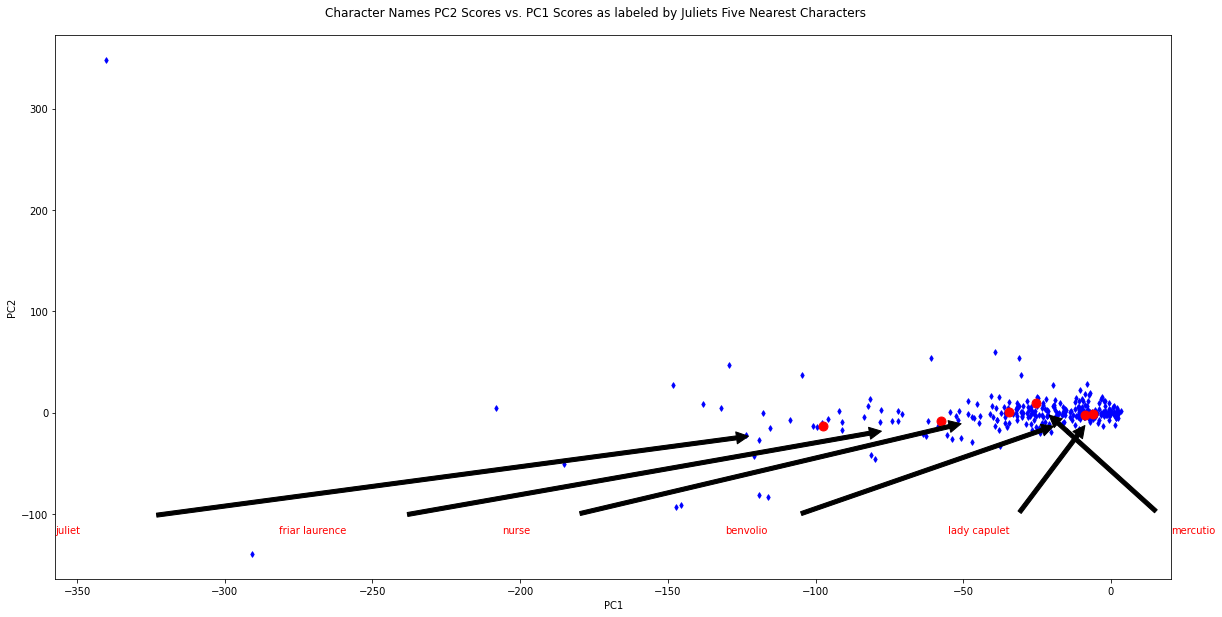

None

In [ ]:
# now plot the data that pertains to cluster 2, where juliet belongs. We only used 5 clusters in question 4, but these k values, were more or less, arbitrarily selected.
# A small k value minimizes the run time for question 4 and is sufficient for ensuring that we can isolate the nearest characters that we are trying to identify
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
#this for loop plots all of the other characters in blue
for i in range(6,X.shape[0]):
  ax.scatter(X[i,0], X[i,1], marker='d', c='blue',s=15)
#these lines of code identify the nearest 4 characters to juliet and mark them red
for i in range(6):
  ax.scatter(X[i,0], X[i,1], marker='o', c='red',s=80)
#titling our plot
fig.suptitle("Character Names PC2 Scores vs. PC1 Scores as labeled by Juliets Five Nearest Characters", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
#annotating our plot using arrows
for i, txt in zip(range(6),character_names):
    ax.annotate(txt, xy = (X[i,0], X[i,1]),  xycoords='data',
                xytext=((i)/5, 0.08), textcoords='axes fraction', color = 'red',
                arrowprops=dict(facecolor='black', shrink=0.1),
                horizontalalignment='left', verticalalignment='bottom',
                )   
display(plt.show())

This biplot shows loading vectors for first two principal components.
The left and bottom axes are showing principal component scores.

# Performing Inference Analysis on the most and least important words according to our PC1 Loading vector
Perform an inference analysis on the 10 most and 10 least important words in the data set as defined by the absolute value of the PC1 loading vector coefficients.  Present the data by loading and printing 2 Pandas data frames containing the 10 most important words and 10 least important words named `most_imp_df` and `least_imp_df` respectively.  The data frames shall have 2 columns named `word` and `loading`.  Provide a written interpretation of the word importances.  You can use pipe_pca_2 for this question.

In [ ]:
# your code here
import pandas as pd
pipe_pca_2.stages
#obtaining the pc_loadings for pc1 and pc2 from our pipeline
pca_data = pipe_pca_2.stages[-1]
pc1 = pca_data.pc.toArray()[:, 0].tolist()
pc2 = pca_data.pc.toArray()[:, 1].tolist()
#pulling the vocabulary from our vectorized data
vocabulary = pipe_pca_2.stages[2].vocabulary
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2'})
print(pc_loadings.shape)
# smallest and biggest loadings of pc2
pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail()))

(7420, 3)


,word,load_pc1,load_pc2
337,edward,-0.0569548,-0.142281
2,d,-0.145836,-0.140443
230,henry,-0.0570768,-0.132887
255,york,-0.0462479,-0.12209
680,clarence,-0.0520519,-0.115429
981,bardolph,-0.0348145,0.146629
673,chief,-0.0536171,0.169805
650,shallow,-0.043524,0.17051
40,master,-0.0708447,0.228336
801,ford,-0.0495372,0.228587


In [ ]:
pc_loadings

,word,load_pc1,load_pc2
0,s,-0.146348,0.0164322
1,thou,-0.261477,0.0337716
2,d,-0.145836,-0.140443
3,thy,-0.177647,-0.0682736
4,shall,-0.1079,0.00298656
...,...,...,...
7415,loosed,-0.00130302,-0.00262239
7416,neapolitan,-0.00163413,-0.00186936
7417,virtuously,-0.0025955,0.00825117
7418,flax,-0.000713996,0.00151487


In [ ]:
# your code here
from  pyspark.sql.functions import abs
pc_loadings['load_pc1'] = pc_loadings['load_pc1'].abs()
#showing our least and most important words derived from our pc_1 loading vectors
least_imp_df = pc_loadings.sort_values('load_pc1').head(10)
most_imp_df = pc_loadings.sort_values('load_pc1').tail(10)
#renaming our columns and dropping our second principle component
most_imp_df.rename(columns = {'load_pc1':'loading'}, inplace = True)
least_imp_df.rename(columns = {'load_pc1':'loading'}, inplace = True)
most_imp_df.drop(['load_pc2'], axis=1, inplace=True)
least_imp_df.drop(['load_pc2'], axis=1, inplace=True)

In [ ]:
# grading cell - do not modify
display(most_imp_df)
display(least_imp_df)

,word,loading
11,ll,0.103529
21,king,0.107898
4,shall,0.1079
6,o,0.110499
13,love,0.111923
2,d,0.145836
0,s,0.146348
5,thee,0.161189
3,thy,0.177647
1,thou,0.261477


,word,loading
5757,carthage,1.13729e-06
7010,musters,2.43313e-06
6175,doubled,4.05251e-06
7003,oats,9.65708e-06
5426,leonine,3.24054e-05
5181,cauldron,3.99136e-05
6784,montagues,4.47745e-05
7248,darken,6.66397e-05
5913,epidamnum,7.60361e-05
7119,cape,8.8974e-05


Your explanation here:
Loadings describe how much each variable contributes to a particular pc1. Large loading values indicate that a variable has a strong relationship to our Principle Components, while the sign indicates whether it's positively or negatively correlated. Given that we were instructed to take the absolute value of these words, we won't focus on (+ or -) correlations but rather we've simply taken their strengths into account. The above words indicate to me that more rigorous cleaning could've taken place to remove words in our 'most_imp_df' that simply don't carry a lot of meaning. For instance, elizabethan word's that have apostropohes seemed to have been tokenized for what comes after the punctuation. It's clear that 'o' or 's' or 'd' shouldn't be in the running for the strongest pc correlation. The least important words were more appropriate, given that they refer to carthage (a place) the montague family, oats and other words. The most important word in our dataframe is II which refers to which generation a name was given. This indicates that there is always room for improvement in cleaning the textual data before performing PCA and kmeans clustering. 

# Part 2: K-Means Clustering

# Obtaining Silhouette Scores for finding the Optimal Number of Clusters, K
Use the `chars_pca_df` from question 2 above and compute K-Means silhouette scores for K = 2 through 6 on the PCA score data. You are free to create a new dataframe to reorganize the PCA data or regenerate the data in chars_pca_df if you wish.   Train your model on each K 3 times to find the lowest silhouette score.  The silhouette score is a measure of within cluster variation.  Remember that because K-Means starts out with random cluster assignments, it is not guaranteed to find a global minima so you should make multiple runs to find the highest score.  Plot the silhouette scores vs. K and report the highest silhouette score from the plot. If the process of finding the lowest silhouette scores is taking too much time, reduce the number of PCA score columns such that you capture a reasonable amount of variance but complete training in a more reasonable amount of time.  The work you did in question 3 above could be useful here.

In [ ]:
#importing our cross validator and param grid builder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

###Silhoutte Scoring: 
######The Silhouette technique measures separability between clusters by measuring the average distance between each point and all other points within the cluster. This is known as intra-class variance essentially, and this method is utilized by kmeans in order to minimize that value, making for very coherent clusters. Following the average distance distance measurements between each point, another measurement compares the distance between those points and each point in other clusters. By subtracting the two average measures and dividing by whichever value is larger, we can obtain a silhouette score for that value. We want to find a silhouette score that is closest to 1 for choosing an optimal K, because a high score would indicate that there is a small intra-cluster distance on average (high cluster coherency) as well as large inter-cluster distances on average (good separation)

In [ ]:
# your code here
from pyspark.ml.evaluation import ClusteringEvaluator as ev
#first we rename tfidf to features and create empty lists to store our silhouette scores and corresponding k values
q7 = chars_pca_df.withColumnRenamed('tfidf','features')
sil_list = []
k = []
#the cross validation section was removed as it would run succesfully about 50% of the time. 
#The scores without cross validation are commensurate to the scores while using it which is why I
#have sufficient reason to believe that these scores were not the result of a local minima, rather a global minima.
#initializing any empty parameter grid. 
#There isn't too many hyperparameters we can tune from a kmeans algorithm, 
#and most of the computing power will be taken from testing different k values (3,7) 
#and cross validating our results to ensure that we're not stuck within a local minima.
#paramgrid =ParamGridBuilder().build()
#for loop to test different k values within our data. This is a 3 fold cross validation
for i in range(2,7):
  kmeans = clustering.KMeans().setK(i).setSeed(1)
  #kmeans = clustering.KMeans(k=i, featuresCol='features').setSeed(42)
  # crossval= CrossValidator(estimator=kmeans,  
  #                        estimatorParamMaps=paramgrid,
  #                        evaluator = ev(), 
  #                        numFolds=3)
  #fitting our crossval code to our model on our question 7 data frame
  model = kmeans.fit(q7)
  #transforming our data frame using our model to generate predictions
  predictions = model.transform(q7)
  #evaluator = ev()
  #evaluating our predictions and appending our values to our empty lists for k and silhouette scores
  silhouette = ev().evaluate(predictions)
  print("Silhouette with squared euclidean distance = " + str(silhouette))
  sil_list.append(silhouette)
  k.append(i)

Silhouette with squared euclidean distance = 0.8339005718979999
Silhouette with squared euclidean distance = 0.8272686173999495
Silhouette with squared euclidean distance = 0.7974702441303817
Silhouette with squared euclidean distance = 0.6250415714092977
Silhouette with squared euclidean distance = 0.7155639811239567


In [ ]:
#placing our scores and k values into a dataframe to plot
sil_df = pd.DataFrame(
    {'K': k,
     'Silhouette Score': sil_list})

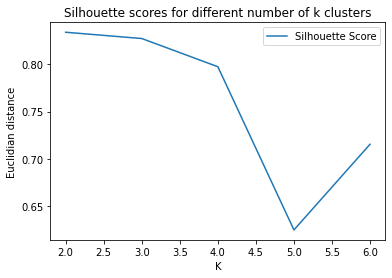

In [ ]:
# Draw a line chart of sillhouette scores vs. K
import matplotlib.pyplot as plt
sil_df.plot.line(x = 'K',y='Silhouette Score', title="Silhouette scores for different number of k clusters");
plt.ylabel('Euclidian distance')
plt.show(block=True)

# Putting it all together: KMeans Clustering Visualization in Conjunction with PCA
Perform K-Means clustering using the `chars_pca_df` and plot the results using a scatter plot.  Color the points by cluster assignment.  You are allowed to create a new dataframe from chars_pca_df or regenerate the data if you wish.  The work you did in question 7 above can be applied directly to this problem.  The goal of this question is to try to find an interesting insight about the Shakespeare characters.  For example, perhaps you spot one or more outlier characters that stands apart from the rest of the characters in the cluster.  An example of this is how IST-718 and IST-719 stand out from the rest of the cluster in the unsupervised learning notebook presented in class (though that plot did not use K-Means clustering, it only used PCA).  Note that in the previous example, I am only providing an example of 1 type of interesting insight.  When you find something interesting, add labels to the points of interest so that the reader of your plot can understand the insight.  Provide an explanation of your insight.  This question is completely open ended and you are free to generate the clusters any way you see fit as long as you use K-Means and your methodology follows good data science practices.  You can plot the observation data in 2 dimensions by using PC1 and PC2 as the X and Y coordinates.  Your plot should be easy to read and not overly cluttered.  This question will be graded on your level of effort in comparison to what insights other students in the class find.

In [ ]:
# your code here
#firstly we run almost identical code to that ran in question 7 except we specify the number of clusters that provided the highest sillhouete score
#this value turned out to be 2 from our plot above
from pyspark.ml.evaluation import ClusteringEvaluator as ev
q8 = chars_pca_df.withColumnRenamed('tfidf','features')
#initializing an empty param grid
paramgrid =ParamGridBuilder().build()
#specifying the parameters
kmeans = clustering.KMeans().setK(2)
#fitting our kmeans model to the question 8 dataframe
model = kmeans.fit(q8)
#storing our predictions in a dataframe for a plot
predictions = model.transform(q8)

In [ ]:
first_k = predictions.filter(predictions.prediction==0)
second_k = predictions.filter(predictions.prediction==1)
#third_k = predictions.filter(predictions.prediction==2)
#four_k = predictions.filter(predictions.prediction==3)

X0 = np.array(first_k.select('scores').rdd.map(lambda x: x['scores']).collect())
X1 = np.array(second_k.select('scores').rdd.map(lambda x: x['scores']).collect())
#X2 = np.array(third_k.select('scores').rdd.map(lambda x: x['scores']).collect())
#X3 = np.array(four_k.select('scores').rdd.map(lambda x: x['scores']).collect())

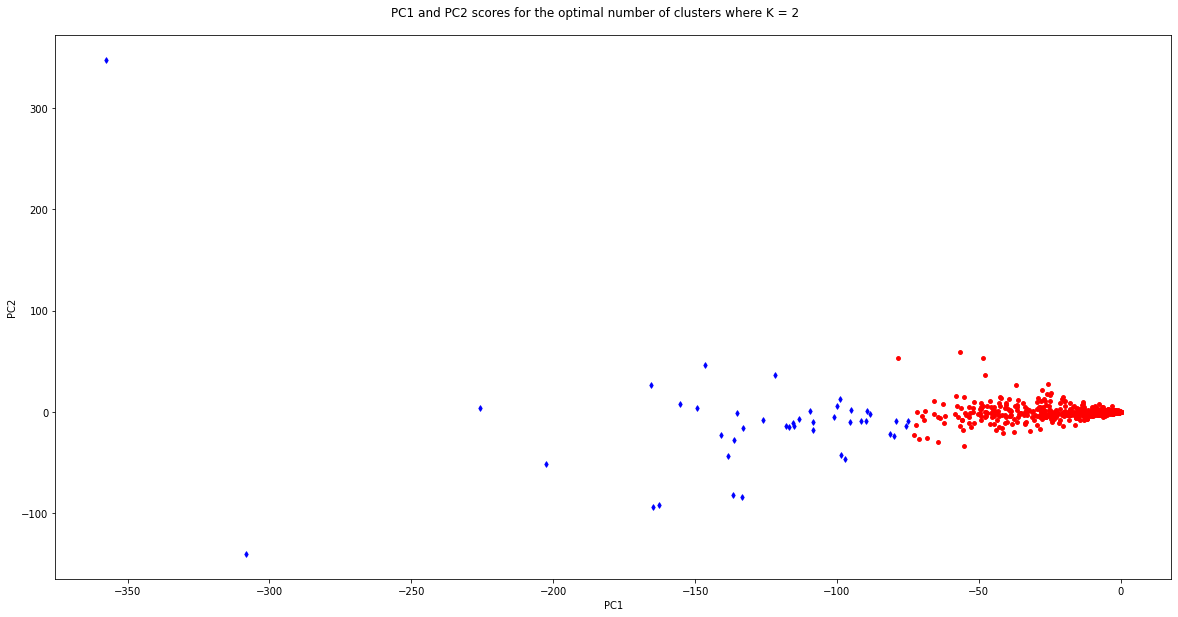

None

In [ ]:
# now plot the data
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)

ax.scatter(X0[:,0], X0[:,1], marker='o', c='red',s=15)
ax.scatter(X1[:,0], X1[:,1], marker='d', c='blue',s=15)
#ax.scatter(X2[:,0], X2[:,1], marker='>', c='green',s=15)
#ax.scatter(X3[:,0], X3[:,1], marker='>', c='green',s=15)

fig.suptitle("PC1 and PC2 scores for the optimal number of clusters where K = 2", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
display(plt.show())

Your insight explanation here:
There are some interesting outliers that are worth discussing in this situation. The first cluster is much more spread out along the x-axis (pc1: -360 to -50) y axis (pc2) than the second cluster. This variance in cluster 1 accounts for all of the outliers that we can identify. The second cluster is much more coherent and uniform along the pc1 axis. It also clusters very nicely around 0 for pc2. Gloucester and falstaff are characters that account for outlier in the cluster where k = 1, as ther are over 150 units away from the nearest character on pc1 (which evidently turns out to be hamlet). 